In [50]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import cv2
import glob

### Calibrate camera and display undistored images

In [51]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx, ny = 9, 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # last element in each cell is left 0

objpoints = [] # 3d points in real world space, as reference.
imgpoints = [] # 2d points in image plane, distorb as much as you can 

cal_paths = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for path in cal_paths:
    cal_image = cv2.imread(path)
    ret, corners = cv2.findChessboardCorners(image = cal_image[:,:,0], patternSize = (nx,ny))
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        print(path)

camera_cal/calibration5.jpg
camera_cal/calibration1.jpg


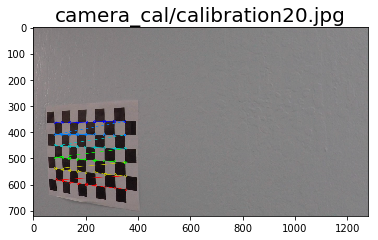

In [52]:
cv2.drawChessboardCorners(cal_image, (nx,ny), corners, ret)
plt.imshow(cal_image)
plt.title(path, fontsize=20)
plt.show()


In [53]:

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cal_image.shape[0:2],None,None)
from sklearn.externals import joblib
joblib.dump((mtx,dist), "9x6dist.p")  # for later use

['9x6dist.p']

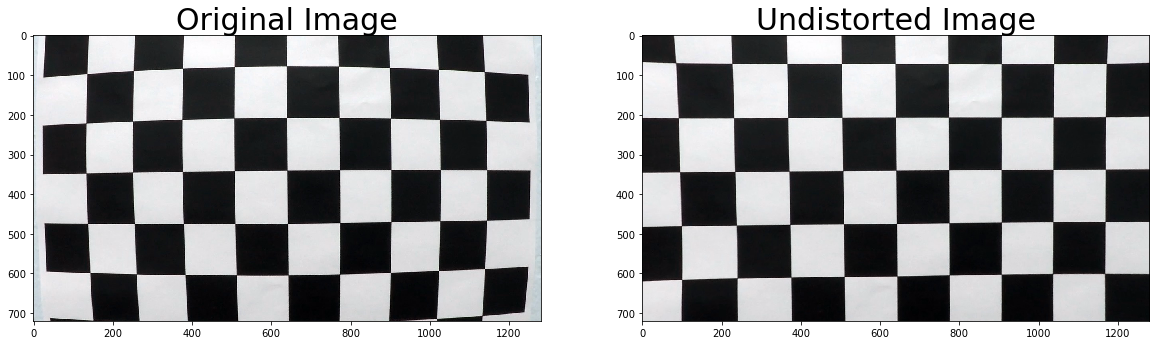

In [57]:
index = np.random.randint(len(cal_paths))
vip = 'camera_cal/calibration1.jpg'
# cal_image = cv2.imread(cal_paths[index])
cal_image = cv2.imread(vip)

dst_image = cv2.undistort(cal_image, mtx, dist, None, mtx)

# Visualize undistortion
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cal_image)
plt.title('Original Image', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(dst_image)
plt.title('Undistorted Image', fontsize=30)
# plt.show()
plt.savefig('./output_images/undistort.png')

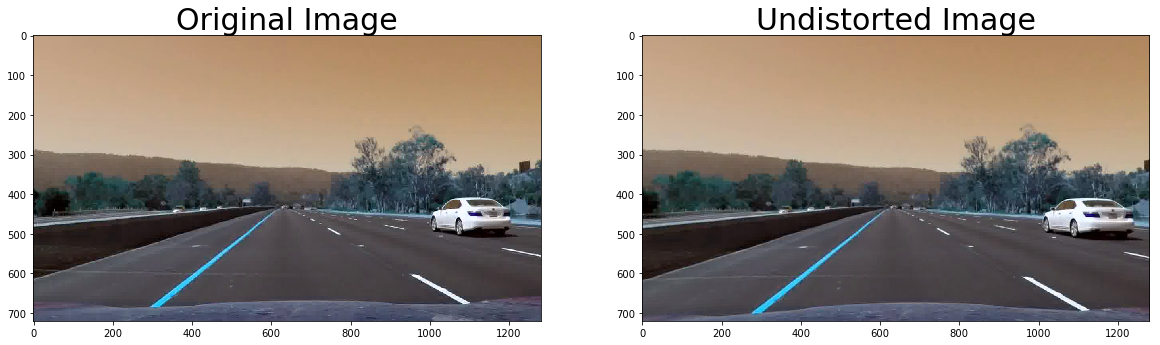

In [58]:
paths = glob.glob('project_frames/*.jpg')
n = len(paths) # 1260


index = np.random.randint(n)
cal_image = cv2.imread(paths[index])
dst_image = cv2.undistort(cal_image, mtx, dist, None, mtx)

# Visualize undistortion
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cal_image)
plt.title('Original Image', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(dst_image)
plt.title('Undistorted Image', fontsize=30)
# plt.show()
plt.savefig('output_images/undistorted_example.png')

#### warp image into topdown view

In [7]:

import matplotlib.image as mpimg
image = mpimg.imread("project_frames/out-311.jpg") # shape (540, 960, 3)


from skimage.viewer import ImageViewer
viewer = ImageViewer(image)
viewer.show() # to read pixel postion


/home/lenovo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


[]

array([[  585.        ,   460.        ],
       [  203.33332825,   720.        ],
       [ 1126.66662598,   720.        ],
       [  695.        ,   460.        ]], dtype=float32)

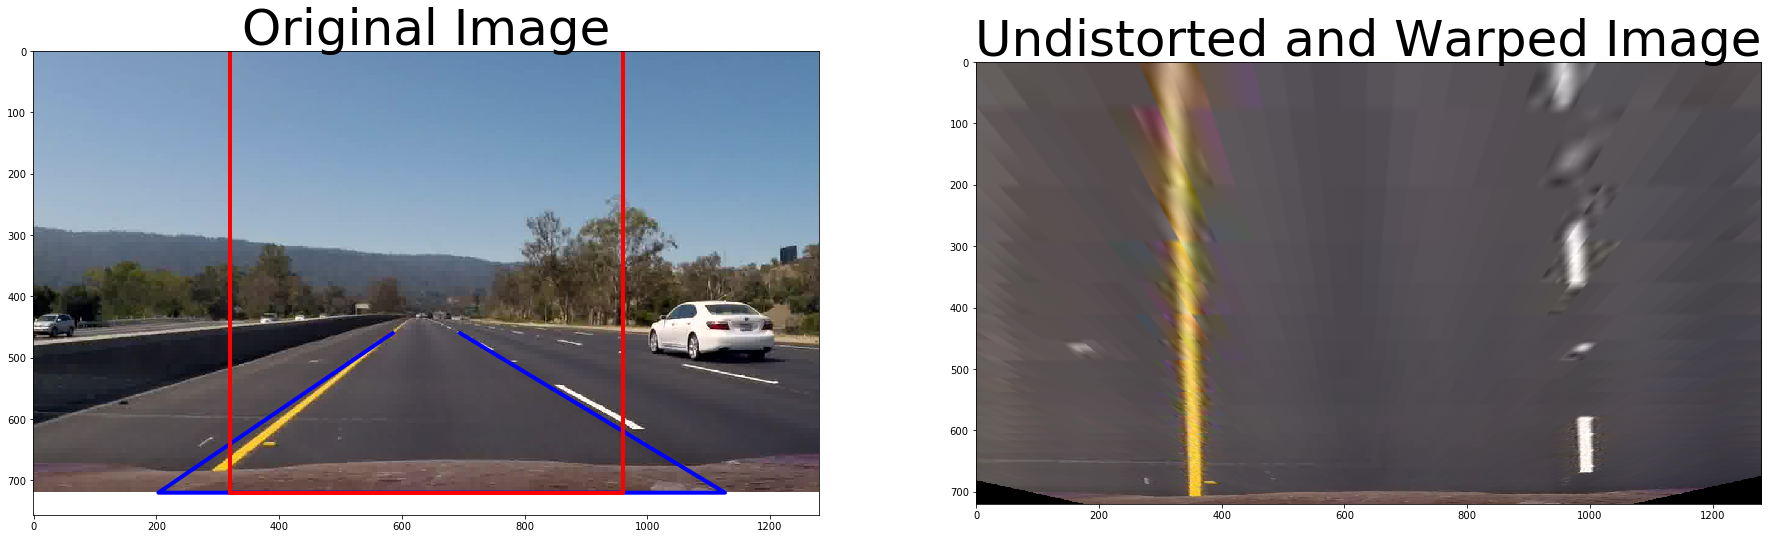

In [61]:
src = np.float32([[360,640],[480,550],[860,550],[1040,640]])
dst = np.float32([[480,640],[480,550],[860,550],[860,640]])

ymax,xmax = image.shape[0:2]
src = np.float32([[xmax/2-55, ymax/2+100],[xmax/6-10, ymax],[xmax*5/6+60,ymax],[xmax/2+55, ymax/2+100]])
dst = np.float32([[xmax/4, 0],            [xmax/4, ymax],   [xmax*3/4, ymax],  [xmax*3/4, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
top_down = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

f = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(image)
plt.plot(src[:,0],src[:,1],color='blue',linewidth = 4)
plt.plot(dst[:,0],dst[:,1],color='red',linewidth = 4)
plt.title('Original Image', fontsize=50)

plt.subplot(122)
plt.imshow(top_down)

plt.title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# plt.show()
plt.savefig('./output_images/warp_image.jpg')



In [9]:
from sklearn.externals import joblib
joblib.dump((M,Minv), "Ptransform.p") 

['Ptransform.p']

### 2 Create Binary Images
use sobel and color space technique to stand out the lanelines
try different gradients, color space:
1. sobelx gray
2. sobel magnitude
3. sobel angle
4. s-channel
5. soble l-channel
6. r-channel

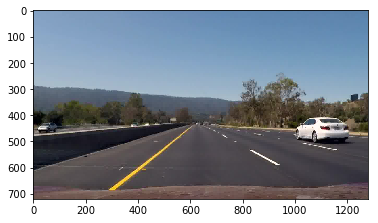

In [10]:
import matplotlib.image as mpimg
import cv2
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.externals import joblib
M, Minv = joblib.load("Ptransform.p")
image = mpimg.imread("project_frames/out-311.jpg")
#image = mpimg.imread("project_video/1000.jpg")
#image = mpimg.imread("project_video/600.jpg")
#image = top_down
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # (720, 1280)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize =3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize =3)
abs_sobelx = np.absolute(sobelx)
abs_sobely = np.absolute(sobely)
plt.imshow(image)

In [11]:
vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)
mask = np.zeros_like(gray)

### 2.1 sobelx

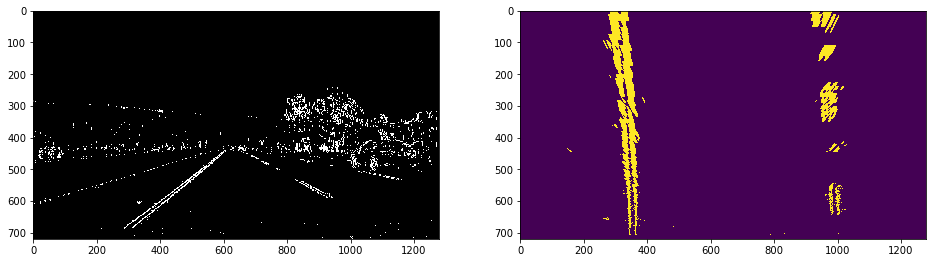

In [13]:
# Create a binary threshold to select pixels based on gradient strength
x_min,x_max = 20,90
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
sobelx_binary = np.zeros_like(gray)
sobelx_binary[(scaled_sobelx  >= x_min) & (scaled_sobelx <= x_max)] = 1
img = sobelx_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

### 2.2 sobel magnitude

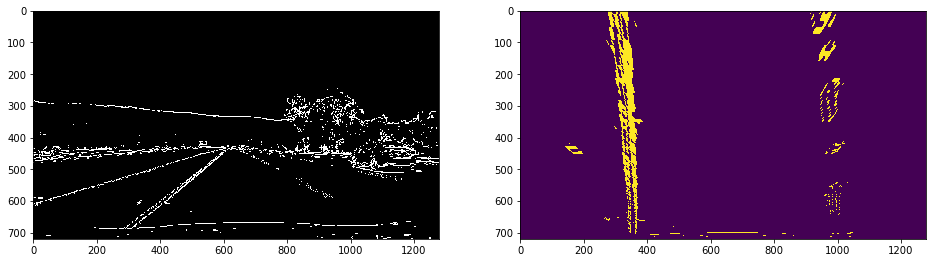

In [14]:
mag_min,mag_max = 30,80
mag = np.sqrt(sobelx**2 + sobely**2)
sacled_mag = np.uint8(255*mag/np.max(mag))
mag_binary = np.zeros_like(gray)
mag_binary[(sacled_mag >= mag_min) & (sacled_mag <= mag_max)] = 1
img = mag_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

### 2.3 soble direction

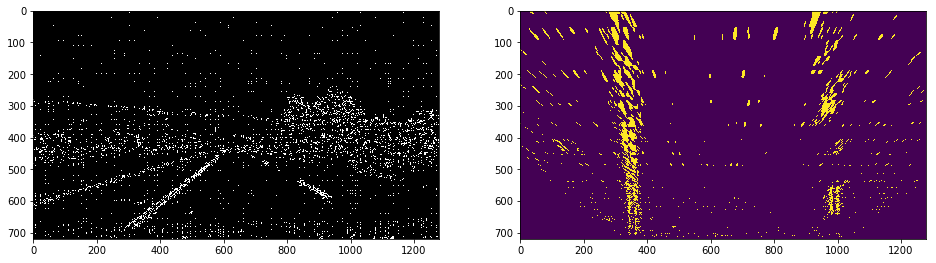

In [15]:
theta_min,theta_max = 0.8, 1.2
angle = np.arctan2(abs_sobely, abs_sobelx)
angle_binary =  np.zeros_like(gray)
angle_binary[(angle >= theta_min) & (angle <= theta_max)] = 1
img = angle_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

### 2.4 s-channel

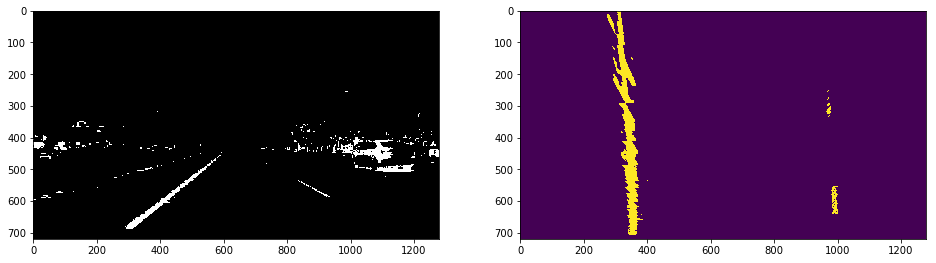

In [16]:
s_min, s_max = 100, 255
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
h,l,s = cv2.split(hls)
s_binary = np.zeros_like(gray)
s_binary[(s > s_min) & (s <= s_max)] = 1
img = s_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

In [17]:
### 2.5 sobelx I-channel

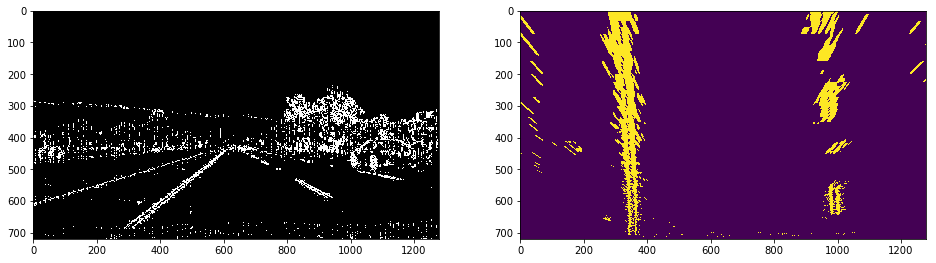

In [18]:
sl_min, sl_max = 10, 250
sobel_l = cv2.Sobel(l, cv2.CV_64F, 1, 0) 
abs_sobel_l = np.absolute(sobel_l) 
sl = np.uint8(255*abs_sobel_l/np.max(abs_sobel_l))
sl_binary = np.zeros_like(gray)
sl_binary[(sl >= sl_min) & (sl <= sl_max)] = 1
img = sl_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
#plt.imshow(top_down)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

In [19]:
### 2.6 red-channel

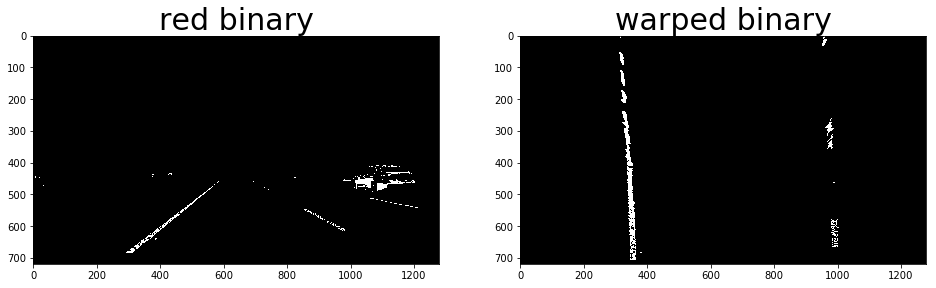

In [59]:
red_min, red_max = 210, 255
r, g, b = cv2.split(image)
red_binary = np.zeros_like(gray)
red_binary [(r> red_min)& (r < red_max)] = 1
img = red_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('red binary', fontsize=30)
plt.subplot(122)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down, cmap='gray')
plt.title('warped binary', fontsize=30)
plt.savefig('output_images/red_binary.png')

# 3. get laneline position and curvation
1. estimate initial center points 
2. use windows to pin down centers and collect lane line points for fitting
3. use fitting coefficient for next image
4. calculate the curvation and write "radius and off-center" info onto the image

In [22]:
### 3.1 estimate initial center points

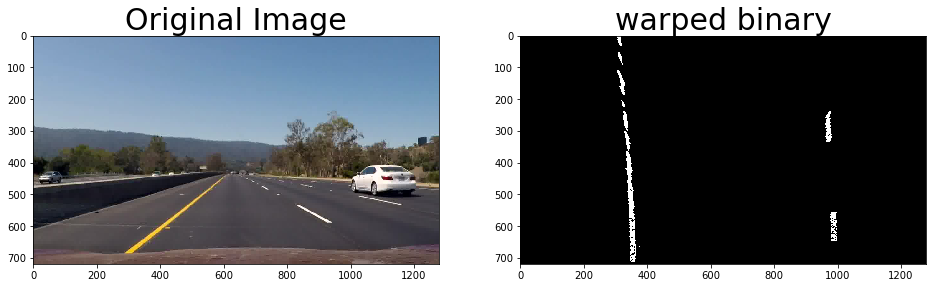

In [64]:
# reproduce warped binary from start: rgb -> undistort ->  r -> binary -> mask -> warp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import cv2
from sklearn.externals import joblib

image = mpimg.imread("project_frames/out-311.jpg")   # always use matplotlib to read and display image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # (720, 1280)

mtx, dist = joblib.load("9x6dist.p")
undist_image = cv2.undistort(image, mtx, dist, None, mtx)

red_min, red_max = 210, 255
r, g, b = cv2.split(undist_image)
red_binary = np.zeros_like(gray)
red_binary [(r> red_min)& (r < red_max)] = 1

vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)
mask = np.zeros_like(gray)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_binary = cv2.bitwise_and(mask,red_binary)

M, Minv = joblib.load("Ptransform.p") 
warped = cv2.warpPerspective(masked_binary, M, (gray.shape[1],gray.shape[0]))

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image', fontsize=30)
plt.subplot(122)
plt.imshow(warped,cmap = "gray")
plt.title('warped binary', fontsize=30)
plt.show()

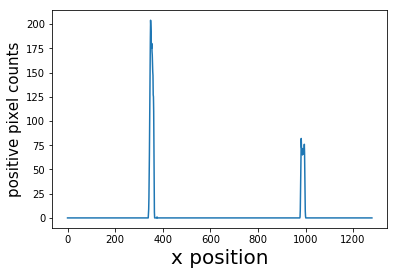

In [65]:
import numpy as np
xcount = np.sum(warped[500:], axis=0)
plt.plot(xcount)
plt.xlabel("x position", fontsize= 20)
plt.ylabel("positive pixel counts", fontsize= 15)
# plt.show()
plt.savefig('./output_images/histogram.png')

In [66]:
center1 = np.argmax(xcount[:600])
center2 = np.argmax(xcount[600:]) + 600
print("initial center x position:",center1," and ",center2)

initial center x position: 349  and  982


### 3.2 use windows to pin down centers and collect lane line points

In [67]:
nwindows = 9
window_height = np.int(warped.shape[0]/nwindows)  # 80
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100 # Set the width of the windows +/- margin
minpix = 50 # Set minimum number of pixels found to recenter

In [68]:
# Create empty lists to receive left and right lane pixel indices
lane1 = []
lane2 = []
win_img = np.dstack((warped, warped, warped))*255 # prepare image to draw window

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    y_min = warped.shape[0] - (window+1)*window_height
    y_max = warped.shape[0] - window*window_height
    x1_min, x1_max = center1 - margin, center1 + margin
    x2_min, x2_max = center2 - margin, center2 + margin
    # Draw the windows 
    cv2.rectangle(win_img,(x1_min,y_min),(x1_max,y_max),(0,0,255), 6) 
    cv2.rectangle(win_img,(x2_min,y_min),(x2_max,y_max),(0,0,255), 6) 
    # Identify the nonzero pixels in x and y within the window
    select1 = ((nonzeroy >= y_min) & (nonzeroy < y_max) & (nonzerox >= x1_min) & (nonzerox < x1_max)).nonzero()[0]
    select2 = ((nonzeroy >= y_min) & (nonzeroy < y_max) & (nonzerox >= x2_min) & (nonzerox < x2_max)).nonzero()[0]
    # Append these indices to the lists
    lane1.append(select1)
    lane2.append(select2)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(select1) > minpix:
        center1 = np.int(np.mean(nonzerox[select1]))
    if len(select2) > minpix:        
        center2 = np.int(np.mean(nonzerox[select2]))

# Concatenate the arrays of indices
lane1_index = np.concatenate(lane1)
lane2_index = np.concatenate(lane2)

# Extract left and right line pixel positions
x1, y1  = nonzerox[lane1_index], nonzeroy[lane1_index] 
x2, y2  = nonzerox[lane2_index], nonzeroy[lane2_index] 

# Fit a second order polynomial to each
fit1 = np.polyfit(y1, x1, 2)
fit2 = np.polyfit(y2, x2, 2)

In [69]:
from sklearn.externals import joblib
joblib.dump((fit1,fit2), "fit.p") 

['fit.p']

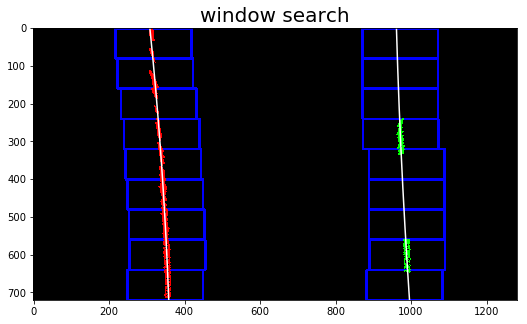

In [70]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
fitx1 = fit1[0]*ploty**2 + fit1[1]*ploty + fit1[2]  # generate points by fit coeff
fitx2 = fit2[0]*ploty**2 + fit2[1]*ploty + fit2[2]
win_img[y1,x1] = [255, 0 , 0]  # factual points
win_img[y2,x2] = [0,  255, 0]
plt.figure(figsize=(10,5))
plt.imshow(win_img)
plt.plot(fitx1, ploty, color='white')
plt.plot(fitx2, ploty, color='white')
plt.title("window search", fontsize = 20)
# plt.show()
plt.savefig('./output_images/window_search.png')

### 3.3 use fitting coefficient for next image

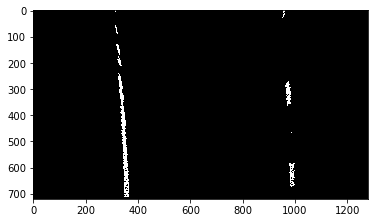

In [73]:
# preprocessing another image
image = mpimg.imread("project_frames/out-312.jpg")   # always use matplotlib to read and display image
undist_image = cv2.undistort(image, mtx, dist, None, mtx)
r, g, b = cv2.split(undist_image)
red_binary = np.zeros_like(gray)
red_binary [(r> red_min)& (r < red_max)] = 1
mask = np.zeros_like(gray)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_binary = cv2.bitwise_and(mask,red_binary)
warped = cv2.warpPerspective(masked_binary, M, (gray.shape[1],gray.shape[0]))
plt.imshow(warped, cmap="gray")


In [74]:
fit1,fit2 = joblib.load("fit.p")
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
fitx1 = fit1[0]*(nonzeroy**2) + fit1[1]*nonzeroy + fit1[2] # x value on the curve for every nonzero point
fitx2 = fit2[0]*(nonzeroy**2) + fit2[1]*nonzeroy + fit2[2]
lane1_index = ((nonzerox > fitx1 - margin) & (nonzerox < fitx1 + margin)) 
lane2_index = ((nonzerox > fitx2 - margin) & (nonzerox < fitx2 + margin)) 

# extract left and right line pixel positions
x1,y1 = nonzerox[lane1_index], nonzeroy[lane1_index]
x2,y2 = nonzerox[lane2_index], nonzeroy[lane2_index]
# New fitting parameters
fit1 = np.polyfit(y1, x1, 2)
fit2 = np.polyfit(y2, x2, 2)
# Generate x and y values using new fit coeff
fitx1 = fit1[0]*ploty**2 + fit1[1]*ploty + fit1[2]  # generate points by fit coeff
fitx2 = fit2[0]*ploty**2 + fit2[1]*ploty + fit2[2]


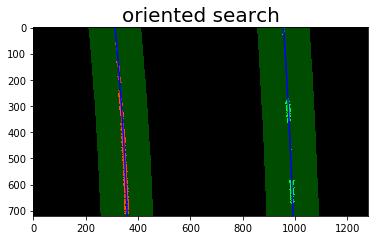

In [75]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
out_img[y1,x1] = [255, 0 , 0]  # factual points
out_img[y2,x2] = [0,  255, 0]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
window_img = np.zeros_like(out_img)
left_line_window1 = np.array([np.transpose(np.vstack([fitx1-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx1+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([fitx2-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx2+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(fitx1, ploty, color='blue')
plt.plot(fitx2, ploty, color='blue')
plt.title("oriented search", fontsize = 20)
# plt.show()
plt.savefig('./output_images/fitting.jpg')

### 3.4 calculate the curvation and write "radius and off-center" info onto the image

In [76]:
def curvature(fit, y):
    A, B = fit[0], fit[1]
    return (1+(2*A*y+B)**2)**1.5/np.absolute(2*A)

In [77]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# calibrated coefficients 
fit1_cal = np.polyfit(ploty*ym_per_pix, fitx1*xm_per_pix, 2)
fit2_cal = np.polyfit(ploty*ym_per_pix, fitx2*xm_per_pix, 2)
# Calculate the new radii of curvature
curv1 = curvature(fit1_cal, 30) # 720 * ym_per_pix
curv2 = curvature(fit2_cal, 30)
print("Curvatures for left lane: {0:.0f} m, right lane: {1:.0f} m".format(curv1,curv2))

Curvatures for left lane: 4180 m, right lane: 7467 m


In [78]:
off_center = -(fitx1[-1]+fitx2[-1]-1280)/2 *xm_per_pix  # assume camera sits in the center of car
print("The car is right to the center by {0:.2f} m".format(off_center))

The car is right to the center by -0.19 m


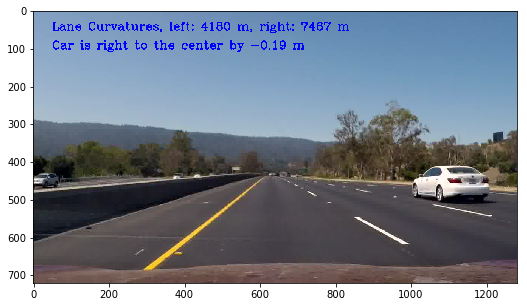

In [80]:
text1 = "Lane Curvatures, left: {0:.0f} m, right: {1:.0f} m".format(curv1,curv2)
text2 = "Car is right to the center by {0:.2f} m".format(off_center)
texted_image =cv2.putText(img=np.copy(image), text= text1, org=(50,50),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
cv2.putText(img=texted_image, text= text2, org=(50,100),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
plt.figure(figsize=(10,5))
plt.imshow(texted_image)
# plt.show()
plt.savefig('output_images/radius.png')

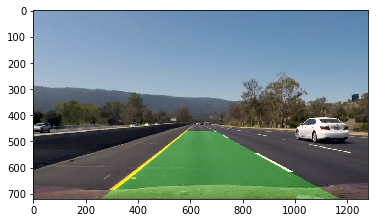

In [81]:
# Create an image to draw the lines on
color_warp = np.zeros((720,1280,3)).astype(np.uint8) 

# Recast the x and y points into usable format for cv2.fillPoly()
pts1 = np.array([np.transpose(np.vstack([fitx1, ploty]))])
pts2 = np.array([np.flipud(np.transpose(np.vstack([fitx2, ploty])))])
pts = np.hstack((pts1, pts2))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.savefig('./output_images/final_draw.png')

In [43]:
### 4. Build pipe line to produce video

In [45]:
from sklearn.externals import joblib
import cv2
import numpy as np
M, Minv = joblib.load("Ptransform.p")
fit1,fit2 = joblib.load("fit.p")
red_min, red_max = 210, 255
vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)

margin = 100
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def curvature(fit, y):
    A, B = fit[0], fit[1]
    return (1+(2*A*y+B)**2)**1.5/np.absolute(2*A)
def pipeline(image):
    global fit1,fit2

    # detailed explanation see section 3.3
    r = image[:,:,0]
    red_binary = np.zeros_like(gray)
    red_binary [(r> red_min)& (r < red_max)] = 1
    mask = np.zeros_like(gray)
    cv2.fillPoly(mask, vertices, 255)
    masked_binary = cv2.bitwise_and(mask,red_binary)
    warped = cv2.warpPerspective(masked_binary, M, (gray.shape[1],gray.shape[0]))

    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    fitx1 = fit1[0]*(nonzeroy**2) + fit1[1]*nonzeroy + fit1[2]
    fitx2 = fit2[0]*(nonzeroy**2) + fit2[1]*nonzeroy + fit2[2]
    lane1_index = ((nonzerox > fitx1 - margin) & (nonzerox < fitx1 + margin))
    lane2_index = ((nonzerox > fitx2 - margin) & (nonzerox < fitx2 + margin))
    x1,y1 = nonzerox[lane1_index], nonzeroy[lane1_index]
    x2,y2 = nonzerox[lane2_index], nonzeroy[lane2_index]
    fit1 = np.polyfit(y1, x1, 2)
    fit2 = np.polyfit(y2, x2, 2)
    # calibrated coefficients
    fitx1 = fit1[0]*ploty**2 + fit1[1]*ploty + fit1[2]  
    fitx2 = fit2[0]*ploty**2 + fit2[1]*ploty + fit2[2]
    fit1_cal = np.polyfit(ploty*ym_per_pix, fitx1*xm_per_pix, 2)
    fit2_cal = np.polyfit(ploty*ym_per_pix, fitx2*xm_per_pix, 2)
    curv1 = curvature(fit1_cal, 30)
    curv2 = curvature(fit2_cal, 30)
    off_center = (fitx1[-1]+fitx2[-1]-1280)/2 *xm_per_pix
    text1 = "Lane Curvatures, left: {0:.0f} m, right: {1:.0f} m".format(curv1,curv2)
    text2 = "Car is right to the center by {0:.2f} m".format(off_center)
    texted_image = np.copy(image)
    cv2.putText(img=texted_image, text= text1, org=(50,50),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
    cv2.putText(img=texted_image, text= text2, org=(50,100),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)

    color_warp = np.zeros((720,1280,3)).astype(np.uint8)
    pts1 = np.array([np.transpose(np.vstack([fitx1, ploty]))])
    pts2 = np.array([np.flipud(np.transpose(np.vstack([fitx2, ploty])))])
    pts = np.hstack((pts1, pts2))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(texted_image, 1, newwarp, 0.3, 0)

    return result

In [46]:
from moviepy.editor import VideoFileClip
output = 'project_output.mp4'
challenge_clip = VideoFileClip('project_video.mp4').fl_image(pipeline)
%time challenge_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [00:47<00:00, 26.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 1min 24s, sys: 2.45 s, total: 1min 26s
Wall time: 48.6 s


In [47]:
from IPython.display import HTML
HTML("""<video width="500"  controls><source src="{0}"></video>
""".format(output))